An implementation of Logisitic regression based on excercise in <b>Python Machine Learning</b> by <i>S. Raschka</i>

In [1]:
from sklearn import datasets


In [2]:
import numpy as np
iris = datasets.load_iris()
X = iris.data[:,[2,3]]
y = iris.target

In [3]:
np.unique(y)

array([0, 1, 2])

so the names of the species are transformed from I.veriscolor, I.setosa, I.virginica as 0,1,2 since ml models works best with numerical data. I need to learn how to do that though - I think I could do it using the pd.Dataframe.fill method 

In [4]:
#Cross validation test split
from sklearn.cross_validation import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X,y, test_size=0.3, random_state=0) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
#feature scaling to perform Z-score  normalisation such that mean is 0 and sigma is 1
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [6]:
#multiclass classification using One vs All method and perceptron model
from sklearn.linear_model import Perceptron #perceptron is simple linear neural network 
ppn = Perceptron(max_iter=40, eta0=0.1, random_state=0)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      max_iter=40, n_iter=None, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False)

eta0 is the learning rate, max_iter is number of epochs. Like all <b>hyperparameters</b>,the right eta and max_iter takes some manual experimentation.  Having trained the Perceptron model, we can make predictions via the predict method

In [7]:
y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' %(y_test!=y_pred).sum())

Misclassified samples: 4


In [8]:
#performance metrics accuracy score
from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' %accuracy_score(y_test, y_pred))  #.2f means 2 decimal points

Accuracy: 0.91


In [9]:
#plot the decision regions of the newly trained model
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X,y, classifier, test_idx=None, resolution=0.02):
    #setup marker generator and color map
    markers = ('s','x','o','^','v')
    colors = ('red','blue', 'lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])  #each color is a number so each colour corresponds to a unique y label
    
    #plot decision surface
    x1_min, x1_max = X[:,0].min() -1, X[:,0].max() + 1  #min and max values for each feature petal width and legnth,  -1 and +1 to extend range
    x2_min, x2_max = X[:,1].min() -1, X[:,1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                np.arange(x2_min, x2_max, resolution))     #meshgrid creates a grid using the feacture vector pairs
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T) #.ravel() unrolls a matrix into  1-D array or vector, .T means transpose
    Z = Z.reshape(xx1.shape)  #Z has dimensions of xx1
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)  #contourf fills region for each label y, classier stores predictions in Z 
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    #plot all samples
    X_test, y_test = X[test_idx,:], y[test_idx]
    for idx, cl in enumerate(np.unique(y)):  #loops over, and returns each element and its counter value
        plt.scatter(x=X[y== cl, 0], y=X[y==cl,1], #positive and negative labels
                    alpha = 0.8, c=cmap(idx), marker=markers[idx], label=cl)
    
    #highlight test samples
    
    if test_idx:  #the index where the testsets starts from 
        X_test, y_test = X[test_idx,:], y[test_idx]
        plt.scatter(X_test[:,0], X_test[:,1], c='', alpha=1.0, linewidth=1, marker='o',
                   s=55, label='test set')

<b> plot_decision_regions purpose</b>    
Aim is to visualise how each value from the predicted and test set was classified to the respected labels or targets
comparing where the trainset vs the test set was classified on the decision surface -  ideally they should be clustered in the same region 

<b> Meshgrid</b>  
A meshgrid is a rectangular grid where each point is an (x,y) coordinate   

x =   0 0 0 0 0        y =   0 1 2 3 4
      1 1 1 1 1              0 1 2 3 4
      2 2 2 2 2              0 1 2 3 4
      3 3 3 3 3              0 1 2 3 4
      4 4 4 4 4              0 1 2 3 4   
such that x[0,1] = 0  and y[0,1] = 1, while x[1,0] = 1 and y[4,3] = 3
      

In [10]:
X_combined_std = np.concatenate((X_train_std, X_test_std), axis=0)  #same as np.vstack but this is old version
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=ppn, test_idx=range(105,150))

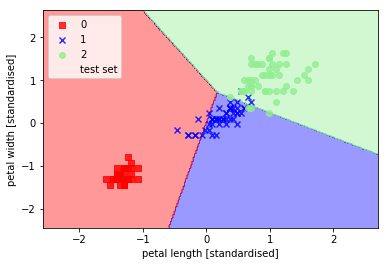

In [11]:
plt.xlabel('petal length [standardised]')
plt.ylabel('petal width [standardised]')
plt.legend(loc='upper left')
plt.show()

Clearly the three flower species cannot be adequately separated by a linear decision boundaries because the Perceptron cannot converge on datasets that aren't linearly separable 

<h3> Now we're gonna implement the actual  Logistic Regression</h3>

In [12]:
#visualise the sigmoid function 
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z)) #recall the  z is the linear combination of the weights and x i.e. theta'X

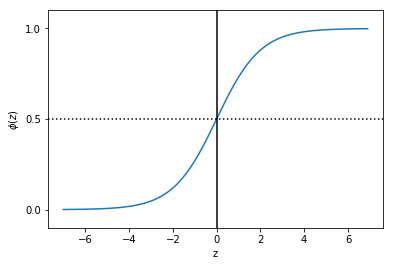

In [13]:
z = np.arange(-7,7,0.1)  #start at -7, increment by 0.1, end at 6
phi_z = sigmoid(z)
plt.plot(z,phi_z)
plt.axvline(0.0, color = 'k')  #add a black vertical line at x=0.0
plt.axhspan(0.0,1.0, facecolor ='1.0', alpha=1.0, ls='dotted')
plt.axhline(y=0.5, ls='dotted', color='k')
plt.yticks([0.0,0.5,1.0])
plt.ylim(-0.1,1.1) #because sigmoid function range from 0 to 1
plt.xlabel('z')
plt.ylabel('$\phi (z)$')
plt.show()


In [14]:
#Train a logistic Regression model

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(X_train_std, y_train)


LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

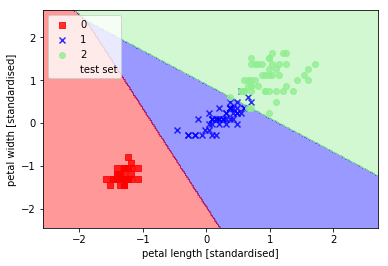

In [15]:
plot_decision_regions(X_combined_std, y_combined, classifier=lr, test_idx=range(105,150))  #test samples are the last 45 out of total 150 samples
plt.xlabel('petal length [standardised]')
plt.ylabel('petal width [standardised]')
plt.legend(loc='upper left')
plt.show()

    Mucho bueno indeeed!

In [16]:
# We can predict the class membership probablity of the each samples
lr.predict_proba(X_test_std[0,:])

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.70793846  1.50872803].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [17]:
#L2 Regularisation - shrinkage or decay method to penalise extreme parameters and prevent overfitting
#Plot L2 regularisation for two weights (parameters)

weights, params = [], []
for c in np.arange(-5 , 5).astype(float):  #w/ .astype gave an error because **c must return output whose datatype is same input 
    lr = LogisticRegression(C=10**c, random_state=0)  #therefore had to change the integer array to a float because a negative power will return a flat
    lr.fit(X_train_std, y_train)   #train logistic regression 
    weights.append(lr.coef_[1])    #returns weight coefficient from log reg training 
    params.append(10**c)            #params is the C values


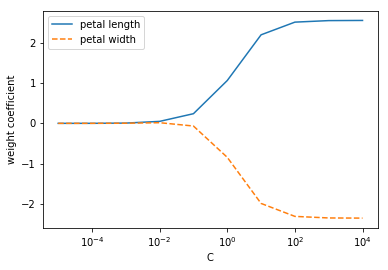

In [18]:
#plot how the weight of each feature changes with the value of the C 
weights = np.array(weights)   #weights is a 2-d array with the weights for each feature petal lenght and petal width
plt.plot(params, weights[:,0],
        label='petal length')
plt.plot(params, weights[:,1], linestyle='--', label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

As the value of C increases, the weights go off the chart! More importantly, decreasing the regularisation increases the regularisation strength

#Support Vector Machines  
<b> SVM</b> is an example of a <i>maximum margin classifier </i> which an give a more robust classification than logistic regression.  
The optimisation objective of a SVM is to minimise the square norm of the weights vector, which in turn produces decision boundary with the largest margin that separates each class.   
SVMs use similarity functions or <b> kernels</b> to learn complex non-linear hypothesis. eg Gaussian (RBF), string kernel, polynomial etc 
<b>C</b> controls the width of the margin, a smaller value of C gives a wider margin while a larger C penalises large misclassification error
See physical notebook for more notes

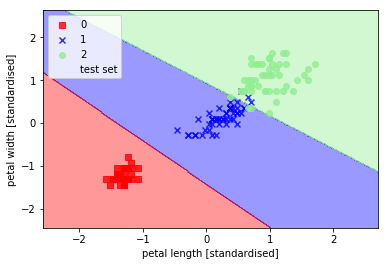

In [19]:
from sklearn.svm import SVC
svm= SVC(kernel='linear', C=1.0, random_state=0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105,150))
plt.xlabel('petal length [standardised]')
plt.ylabel('petal width [standardised]')
plt.legend(loc='upper left')
plt.show()

<h3>Alternative implementations in scikit-learn library</h3>

The perceptron and logistic regression model used previously made use of the <b> LIBLINEAR</b> library which is highly optimised C/C++ library. The SVC class used to train the SVM makes use of the <b>LIBSVM</b> which an equivalent C?C++ library.  

scikit-learn also offers an alternative implementations via the <b>SGDClassifier</b> which supports online learning  

<h3>Solving non-linear problems using a kernel SVM </h3>    

To solve a non-linear problem, the data is transformed into a higher dimensional feature space via a mapping function  
the SVM then trains the data in this new feature space

Below, I'm going to create a sample dataset to see how a non-linear classification problem may look.  
Using the following code, we will create a sample dataset that has the form of a XOR gate using the <b>logical_xor</b> function from NumPy, where 100 samples will be assigned to a class -1 and the other 100 will be assigned to a class of -1


In [20]:
np.random.seed(0)
X_xor = np.random.randn(200,2)   #200x2
y_xor = np.logical_xor(X_xor[:,0]>0, X_xor[:,1] >0 )
y_xor = np.where(y_xor, 1,-1)


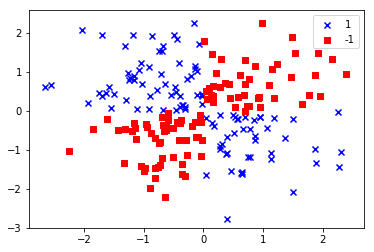

In [21]:
plt.scatter(X_xor[y_xor==1,0], X_xor[y_xor==1,1],
           c= 'b', marker='x', label='1')
plt.scatter(X_xor[y_xor== -1, 0],X_xor[y_xor== -1, 1],
           c= 'r', marker='s', label='-1' )
plt.ylim(-3.0)
plt.legend()
plt.show()

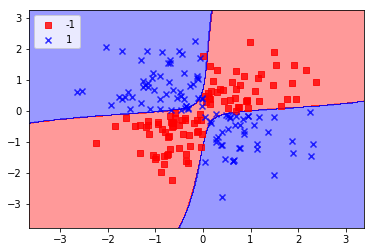

In [22]:
svm = SVC(kernel='rbf', random_state=0, gamma=0.10, C=10.0) #gamma is the cut-off parameter for gaussian spere, recall gamma is inverse of 2*sigma^2
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.show()

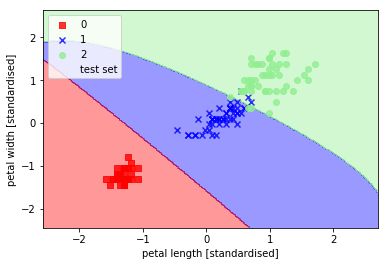

In [23]:
#Train svm on the Iris data
svm= SVC(kernel = 'rbf', random_state=0, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105,150))
plt.xlabel('petal length [standardised]')
plt.ylabel('petal width [standardised]')
plt.legend(loc='upper left')
plt.show()

a smaller value of gamma resulted in a 'softer' decision boundary, let's see the effect of increasing gamma 

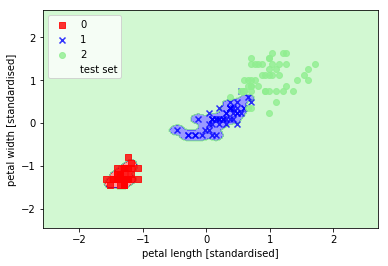

In [24]:
svm= SVC(kernel = 'rbf', random_state=0, gamma=100, C=1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105,150))
plt.xlabel('petal length [standardised]')
plt.ylabel('petal width [standardised]')
plt.legend(loc='upper left')
plt.show()

with an increase in gamma, the decision boundary is tigther than before. However such a model will have high generalisation error that is prone to overfitting